In [1]:
import pandas as pd
import json
from glob import glob
import numpy as np
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ocr_files = glob('data/ocr_alto/*.json')

In [3]:
df_rep = pd.read_excel('repertoires.xlsx')
df_rep.dropna(subset=['nom_court'], inplace=True)
df_rep['ids'] = df_rep['lien_source'].str.replace('https://gallica.bnf.fr/ark:/12148/', '')
df_rep['vue_debut'] = df_rep['vue_debut'].astype(int)
df_rep['annee'] = df_rep['annee'].astype(int)
# df_rep['annee'] = pd.to_datetime(df_rep['annee'].astype(int), format='%Y')
df_rep.set_index('ids', inplace=True)
df_rep.head()

,nom_court,annee,remarques,lien_source,source_ID,vue_debut,page_debut,vue_fin,page_fin,page_total,pages,nom_fichier
ids,,,,,,,,,,,,
bpt6k63243601,Annuaire-general-du-commerce,1839,NaN,https://gallica.bnf.fr/ark:/12148/bpt6k63243601,FRBNF32698036,123,103.0,399.0,379,1457,277.0,bpt6k63243601.Alto.html
bpt6k62931221,Annuaire-general-du-commerce,1841,"document en 2 parties sur Gallica, seule la pr...",https://gallica.bnf.fr/ark:/12148/bpt6k62931221,FRBNF32698036,151,72.0,423.0,344,938,273.0,bpt6k62931221.Alto.html
bpt6k6286466w,Annuaire-general-du-commerce,1842,"document en 2 parties sur Gallica, seule la pr...",https://gallica.bnf.fr/ark:/12148/bpt6k6286466w,FRBNF32698036,189,91.0,489.0,391,939,301.0,bpt6k6286466w.Alto.html
bpt6k6393838j,Annuaire-general-du-commerce,1843,"document en 2 parties sur Gallica, seule la pr...",https://gallica.bnf.fr/ark:/12148/bpt6k6393838j,FRBNF32698036,219,107.0,482.0,378,969,264.0,bpt6k6393838j.Alto.html
bpt6k6331310g,Annuaire-general-du-commerce,1844,La dernière page comprend le début d'une autre...,https://gallica.bnf.fr/ark:/12148/bpt6k6331310g,FRBNF32698036,216,103.0,483.0,372,977,268.0,bpt6k6331310g.Alto.html


In [4]:
df = pd.read_pickle('./data/ocr_alto/gallica_ocr.pickle')

In [ ]:
df = pd.DataFrame(columns = ['text', 'confidence', 'full_text', 'is_hyphen', 'document', 'page', 'block', 'line', 'word'])

for idx_document, ocr_file in tqdm(enumerate(ocr_files[:10])):
    doc_id = ocr_file.split('\\')[-1].split('_')[0]
    vue_debut = int(df_rep.loc[doc_id]['vue_debut'])
    with open(ocr_file, 'r', encoding='utf-8') as infile:
        data = json.load(infile)
    for idx_page, page in tqdm(enumerate(data), leave=False):
        for idx_block, block in enumerate(page):
            for idx_line, line in enumerate(block):
                for idx_word, word in enumerate(line):
                    word['document'] = doc_id
                    word['page'] =  vue_debut + idx_page
                    word['block'] = idx_block
                    word['line'] = idx_line
                    word['word'] = idx_word
                    full_text = word['text']
                    is_hypen = False
                    if 'full_text' in word:
                        full_text = word['full_text']
                        is_hypen = True
                    df.append({'text' : word['text'],
                               'confidence': word['confidence'],
                               'full_text': full_text,
                               'is_hyphen': True,
                               'document' : doc_id,
                               'page' : vue_debut + idx_page,
                               'block' : idx_block,
                               'line': idx_line,
                               'word': idx_word
                              }, ignore_index=True)

In [9]:
rows = []
for idx_document, ocr_file in tqdm(enumerate(ocr_files[:10])):
    doc_id = ocr_file.split('\\')[-1].split('_')[0]
    vue_debut = int(df_rep.loc[doc_id]['vue_debut'])
    with open(ocr_file, 'r', encoding='utf-8') as infile:
        data = json.load(infile)
    for idx_page, page in tqdm(enumerate(data), leave=False):
        for idx_block, block in enumerate(page):
            for idx_line, line in enumerate(block):
                for idx_word, word in enumerate(line):
                    word['document'] = doc_id
                    word['page'] =  vue_debut + idx_page
                    word['block'] = idx_block
                    word['line'] = idx_line
                    word['word'] = idx_word
                    rows.append(word)

In [95]:
df = pd.DataFrame(rows)
df = df[['text', 'confidence', 'full_text', 'is_hypen', 'document', 'page', 'block', 'line', 'word']]
df['is_hypen'] = df['is_hypen'].fillna(False)
df['full_text'] = df['full_text'].fillna(df['text'])
df['confidence'] = df['confidence'].astype(float)
df.set_index(['document', 'page', 'block', 'line', 'word'], inplace=True)
df.head()

text  confidence        full_text  \
document      page block line word                                              
bpt6k6282019m 72.0 0     0    0           Bertin        1.00           Bertin   
                              1                (        1.00                (   
                              2            Mme),        0.99            Mme),   
                              3      sage-femme,        0.99      sage-femme,   
                              4     St-Lquis-Ma-        0.92  St-Lquis-Marais   

                                    is_hypen  
document      page block line word            
bpt6k6282019m 72.0 0     0    0        False  
                              1        False  
                              2        False  
                              3        False  
                              4         True

In [5]:
confidence_per_word = df['confidence']
mean_confidence_per_line = df.groupby(level=[0, 1, 2, 3])['confidence'].mean()
min_per_line = df.groupby(level=[0, 1, 2, 3])['confidence'].min()
mean_confidence_per_block = df.groupby(level= [0,1,2])['confidence'].mean()
mean_confidence_per_page = df.groupby(level=[0,1])['confidence'].mean()
mean_confidence_per_doc = df.groupby(level=[0])['confidence'].mean()

In [ ]:
words_per_line = df.groupby(level=[0,1,2,3]).size()
words_per_block = df.groupby(level=[0,1,2]).size()
lines_per_block = df.reset_index(level=[3, 4]).groupby(level=[0,1,2])['line'].nunique()
block_per_page = df.reset_index(level=[2, 3, 4]).groupby(level=[0,1])['block'].nunique()

In [ ]:
pd.concat([confidence_per_word.describe().to_frame('word'),
           mean_confidence_per_line.describe().to_frame('line'),
           mean_confidence_per_block.describe().to_frame('block'),
           mean_confidence_per_page.describe().to_frame('page'),
           mean_confidence_per_doc.describe().to_frame('doc')], axis=1)

In [ ]:
pd.DataFrame(
    np.vstack([np.percentile(x, [0.01, 0.1, 0.5, 1, 2, 5])
               for x in [confidence_per_word, mean_confidence_per_line, mean_confidence_per_block, mean_confidence_per_page, mean_confidence_per_doc]])
    ,columns=[0.01, 0.1, 0.5, 1, 2, 5]).T.rename(columns=dict(enumerate(['word', 'line', 'block', 'page', 'doc'])))

In [ ]:
np.arange(0, 1, 100)

D:\APPLICATIONS\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


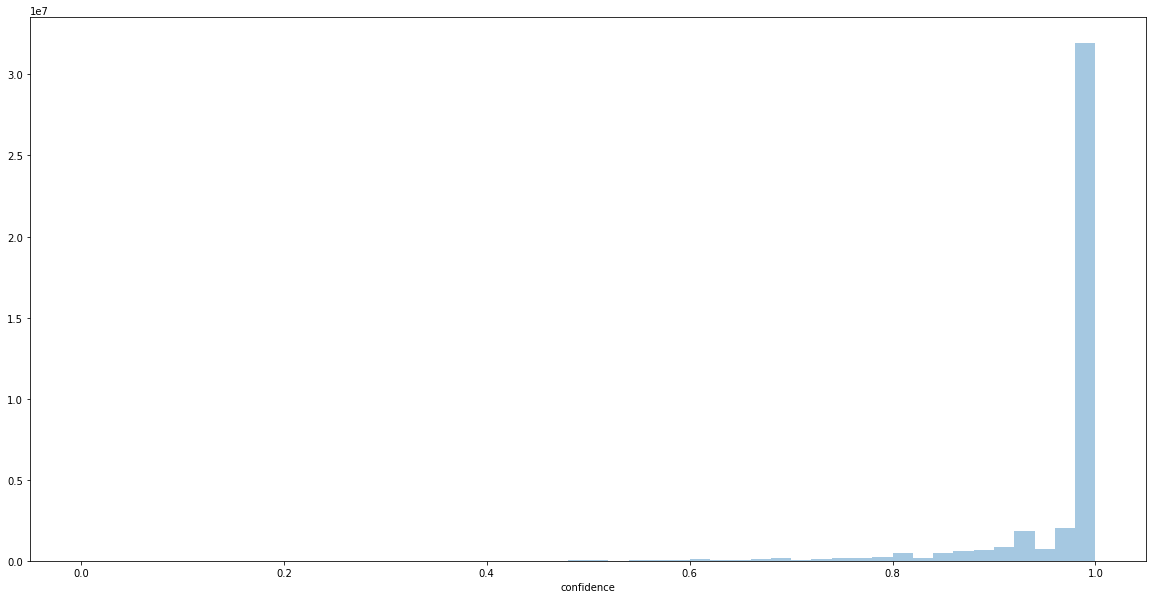

In [49]:
plt.figure(figsize=(20,10))
sns.distplot(mean_per_word, kde=False, bins=)

In [34]:
pd.concat([words_per_line.describe().to_frame('words/line'),
           words_per_block.describe().to_frame('words/block'),
           lines_per_block.describe().to_frame('lines/block'),
           block_per_page.describe().to_frame('blocks/page')], axis=1)

,words/line,words/block,lines/block,blocks/page
count,8.441577e+06,4.370665e+06,4.370665e+06,27574.000000
mean,4.902223e+00,9.468237e+00,1.931417e+00,158.506745
std,1.986829e+00,6.729025e+00,1.149794e+00,26.347408
min,1.000000e+00,1.000000e+00,1.000000e+00,8.000000
25%,4.000000e+00,5.000000e+00,1.000000e+00,140.000000
50%,5.000000e+00,8.000000e+00,2.000000e+00,151.000000
75%,6.000000e+00,1.200000e+01,2.000000e+00,182.000000
max,3.000000e+01,3.500000e+02,5.000000e+01,241.000000


In [19]:
pd.DataFrame(
    np.vstack([np.percentile(x, [50, 75, 90, 95, 99, 99.5, 99.9, 99.99])
               for x in [words_per_line, words_per_block, lines_per_block, block_per_page]])
    ,columns=[50, 75, 90, 95, 99, 99.5, 99.9, 99.99]).T.rename(columns=dict(enumerate(['words/line', 'words/block', 'lines/block', 'blocks/page'])))

,words/line,words/block,lines/block,blocks/page
50.00,5.0,8.0,2.0,151.00
75.00,6.0,12.0,2.0,182.00
90.00,7.0,17.0,3.0,198.00
95.00,8.0,22.0,4.0,204.00
99.00,9.0,34.0,6.0,214.27
99.50,9.0,40.0,7.0,218.00
99.90,10.0,57.0,10.0,225.00
99.99,12.0,93.0,16.0,234.00


In [85]:
df.loc[1, 59, 133]

text  confidence  full_text  is_hypen
line word                                            
0    0     Chaussin,        0.99  Chaussin,     False
     1        peint,        0.99     peint,     False
     2        émaill        0.87     émaill     False
     3            én        0.87         én     False
     4      cadrabs,        0.87   cadrabs,     False
     5       Temple,        0.37    Temple,     False
     6           39.        0.37        39.     False

In [84]:
" ".join(df.loc[1, 59, 133]['text'].values)

'Chaussin, peint, émaill én cadrabs, Temple, 39.'

In [100]:
df[(df['confidence'] > 0.65) & (df['confidence'] < 0.7)].sample(25)

,,,,,text,confidence,full_text,is_hypen
document,page,block,line,word,,,,
bpt6k6292987t,388.0,117,0,3,"(Ils,",0.66,"(Ils,",False
bpt6k6314752k,224.0,29,0,0,"Blocil,",0.69,"Blocil,",False
bpt6k6315927h,597.0,66,2,2,TIOUV.,0.69,TIOUV.,False
bpt6k6315985z,101.0,166,2,2,dé,0.69,dé,False
bpt6k6286466w,454.0,151,0,3,£,0.67,£,False
bpt6k6292987t,370.0,4,0,6,Web,0.66,Web,False
bpt6k6315985z,256.0,185,1,0,65.,0.66,65.,False
bpt6k6315927h,468.0,123,0,3,11.,0.67,11.,False
bpt6k62906378,307.0,107,0,1,"4,",0.67,"4,",False


In [29]:
df[mean_per_line < 0.9]

D:\APPLICATIONS\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


text  confidence  \
document page block line word                                              
0        0    7     0    0                            Bertin        1.00   
                         1            (J.),vins,Roquette,51.        0.84   
                         2                                 *        0.84   
              8     1    0                          Oharaps,        0.82   
                         1                               26.        0.82   
                         2                                ,'        1.00   
              10    0    0                            Bertin        1.00   
                         1                                de        0.95   
                         2                            Chalup        0.95   
                         3                                 4        0.28   
                         4                                 i        0.28   
                         5                            ancien        0.99   
                         6                              chef        1.00   
                         7                       d'escadron,        0.97   
                    1    0                     ViMe-FEveque,        0.69   
                         1                                27        0.94   
                         2                              bis.        0.99   
              12    0    0                               des        1.00   
                         1                       Beaux-Arts,        0.96   
                         2                        Sts-Pères,        0.99   
                         3                                7.        0.58   
              14    0    0                                 l        0.18   
                         1                         Bcrtinot,        0.92   
                         2                             avoué        1.00   
                         3                               Ire        0.96   
                         4                         instance,        0.99   
                         5                         Vivienne,        0.99   
                         6                               10.        1.00   
              24    0    0                            Berton        0.51   
                         1                              (À.)        0.51   
...                                                      ...         ...   
9        322  26    0    5                              eau,        0.78   
                         6                               37.        0.78   
              28    1    0     Nve-St-EHenne-Bonne-Nouvelle,        0.87   
                         1                                2.        0.87   
              55    1    0                            glane,        0.85   
                         1                               lb.        0.57   
              124   0    0                             Bazar        0.89   
                         1                                de        1.00   
                         2                                 V        0.56   
                         3                        Industrie,        0.56   
                         4                       Montmartre,        0.99   
                         5                              180,        1.00   
                         6                                et        1.00   
              128   2    0                       Université,        0.89   
                         1                              126.        0.89   
              136   1    0                             Faub.        0.99   
                         1                       -St-Martin,        0.99   
                         2                             ?'TL.        0.41   
                         3                                 1        0.60   
              166   0    0                             Bazin        1.00   
                         1  

In [10]:
data = df_rep.join(df.groupby(level=[0])['confidence'].mean()).dropna(subset=['confidence'])[['annee', 'confidence']].sort_values(by='annee')

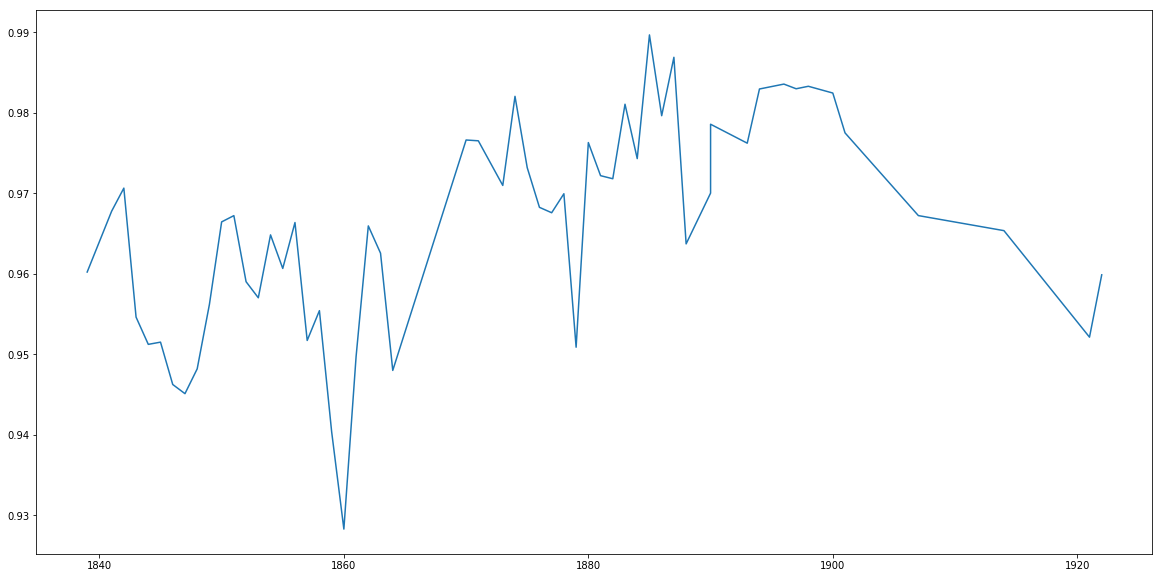

In [12]:
plt.figure(figsize=(20,10))
plt.plot(data['annee'], data['confidence'])